In [69]:
# Import

# Data Analysis
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import savetxt
from numpy import loadtxt

import matplotlib.pyplot as plt

# Text Processing
import re

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer


# Model training and evaluation
from sklearn.model_selection import train_test_split

#Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report


from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# Ignore noise warning
import warnings
warnings.filterwarnings("ignore")

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [83]:
# loading dataset
data_set = pd.read_csv("./archive/combined_mbti_big_five.csv")
data_set.tail()

,type,posts
11928,INFP,I tire of winds and waters and pale lights! An...
11929,INFP,"Guido, Guido, thou hast not spoke this hour, N..."
11930,ISFJ,"Yes, old Pia, good neighbor. Yes, Lisetta will..."
11931,INFP,"Pia. Pia, turn my pillow, I am stifled. I have..."
11932,INFP,I have not eaten food this day. Hast thou Some...


In [84]:
# dataset info
print(data_set.isnull().any(),"\n\n")
nRow, nCol = data_set.shape
print(f'There are {nRow} rows and {nCol} columns\n\n')
print("data types are ", data_set.dtypes,"\n\n")
print(data_set.info())
print(data_set.describe(include=['object']))

type     False
posts    False
dtype: bool 


There are 11933 rows and 2 columns


data types are  type     object
posts    object
dtype: object 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11933 entries, 0 to 11932
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    11933 non-null  object
 1   posts   11933 non-null  object
dtypes: object(2)
memory usage: 186.6+ KB
None
         type                                              posts
count   11933                                              11933
unique     16                                              11927
top      INFP  I am just likely, am I not, to let that creatu...
freq     2045                                                  2


In [85]:
types = np.unique(np.array(data_set['type']))
total = data_set.groupby(['type']).count()

**Preprocessing**

In [86]:
# 각 항목 별 columns 추가 
 
def get_types(row):
    t=row['type']

    I = 0; N = 0
    T = 0; J = 0
    
    if t[0] == 'I': I = 1
    elif t[0] == 'E': I = 0
    else: print('I-E not found') 
        
    if t[1] == 'N': N = 1
    elif t[1] == 'S': N = 0
    else: print('N-S not found')
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
    else: print('T-F not found')
        
    if t[3] == 'J': J = 1
    elif t[3] == 'P': J = 0
    else: print('J-P not found')
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

data = data_set.join(data_set.apply (lambda row: get_types (row),axis=1))
data.head(5)
#IE 

,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,1,1
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,1,1


Introversion (I) /  Extroversion (E):	 3095  /  8838
Intuition (N) / Sensing (S):		 3496  /  8437
Thinking (T) / Feeling (F):		 6720  /  5213
Judging (J) / Perceiving (P):		 7245  /  4688


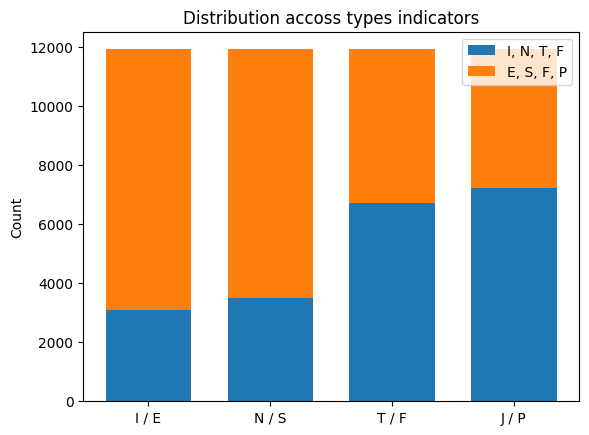

In [87]:
# 항목 별 나온 횟수 
print ("Introversion (I) /  Extroversion (E):\t", data['IE'].value_counts()[0], " / ", data['IE'].value_counts()[1])
print ("Intuition (N) / Sensing (S):\t\t", data['NS'].value_counts()[0], " / ", data['NS'].value_counts()[1])
print ("Thinking (T) / Feeling (F):\t\t", data['TF'].value_counts()[0], " / ", data['TF'].value_counts()[1])
print ("Judging (J) / Perceiving (P):\t\t", data['JP'].value_counts()[0], " / ", data['JP'].value_counts()[1])
#Plotting the distribution of each personality type indicator
N = 4
bottom = (data['IE'].value_counts()[0], data['NS'].value_counts()[0], data['TF'].value_counts()[0], data['JP'].value_counts()[0])
top = (data['IE'].value_counts()[1], data['NS'].value_counts()[1], data['TF'].value_counts()[1], data['JP'].value_counts()[1])

ind = np.arange(N)    # the x locations for the groups
# the width of the bars
width = 0.7           # or len(x) can also be used here

p1 = plt.bar(ind, bottom, width, label="I, N, T, F")
p2 = plt.bar(ind, top, width, bottom=bottom, label="E, S, F, P") 

plt.title('Distribution accoss types indicators')
plt.ylabel('Count')
plt.xticks(ind, ('I / E',  'N / S', 'T / F', 'J / P',))
plt.legend()

plt.show()

In [88]:
# 16가지 MBTI -> Binaryzation

lemmatiser = WordNetLemmatizer()

# Stop word 제거
useless_words = stopwords.words("english")

unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
unique_type_list = [x.lower() for x in unique_type_list]

# Splitting 
binary_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
binary_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    return [binary_Pers[l] for l in personality]

# 결과 출력용
def translate_back(personality):
    # binary vector -> mbti personality
    s = ""
    for i, l in enumerate(personality):
        s += binary_Pers_list[i][l]
    return s

list_personality_bin = np.array([translate_personality(p) for p in data.type])
print("Binarize MBTI list: \n%s" % list_personality_bin)

Binarize MBTI list: 
[[0 0 0 0]
 [1 0 1 1]
 [0 0 1 1]
 ...
 [0 1 0 0]
 [0 0 0 1]
 [0 0 0 1]]


In [89]:
# Noise 제거
def pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True):
  list_personality = []
  list_posts = []
  len_data = len(data)
  i=0
  
  for row in data.iterrows():
      # check code working 
      # i+=1
      # if (i % 500 == 0 or i == 1 or i == len_data):
      #     print("%s of %s rows" % (i, len_data))

      #Remove and clean comments
      posts = row[1].posts

      #Remove url links 
      temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)

      temp = re.sub('\|\|\|',' ',temp)

      # transform mbti to binary vector
      type_labelized = translate_personality(row[1].type) #or use lab_encoder.transform([row[1].type])[0]
      list_personality.append(type_labelized)
      # the cleaned data temp is passed here
      list_posts.append(temp)

  # returns the result
  list_posts = np.array(list_posts)
  list_personality = np.array(list_personality)
  return list_posts, list_personality

list_posts, list_personality  = pre_process_text(data, remove_stop_words=True, remove_mbti_profiles=True)

print("\nPost before preprocessing:\n\n", data.posts[0])
print("\nPost after preprocessing:\n\n", len(list_posts[0]))
print("\nMBTI before preproc essing:\n\n", data.type[0])
print("\nMBTI after preprocessing:\n\n", list_personality[0])


Post before preprocessing:

 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010

In [90]:
print(list_posts)


["'    enfp and intj moments     sportscenter not top ten plays     pranks What has been the most life-changing experience in your life?        On repeat for most of today. May the PerC Experience immerse you. The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~     Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as... 84389  84390       ... Welcome and stuff.    Game. Set. Match. Prozac, wellbrutin, at least thirty minutes of moving your legs (and I don't mean moving them while sitting in your same desk chair), weed in moderation (maybe try edibles as a healthier alternative... Basically come up with three items you've determined that each type (or whichever types you want to do) would more than likely use, given each types' cognitive functions and whatnot, when left by... All things in

In [91]:
personality_types = [ "IE: Introversion (I) / Extroversion (E)", "NS: Intuition (N) / Sensing (S)", 
                   "FT: Feeling (F) / Thinking (T)", "JP: Judging (J) / Perceiving (P)"  ]

for personality_type in personality_types:
    print(personality_type)

IE: Introversion (I) / Extroversion (E)
NS: Intuition (N) / Sensing (S)
FT: Feeling (F) / Thinking (T)
JP: Judging (J) / Perceiving (P)


In [92]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 텍스트 인코딩 함수
def encode_texts(texts, tokenizer, max_length=512):
    encoded = tokenizer(
        list(texts),
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        return_attention_mask=True,
        truncation=True,
        return_tensors='pt'
    )
    return encoded['input_ids'], encoded['attention_mask']

# 커스텀 데이터셋 클래스
class PersonalityDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'label': self.labels[idx]
        }

In [94]:
for i, personality_type in enumerate(personality_types):
    print(f"Training model for personality type {personality_type}...")

    # 현재 유형에 대한 타깃 데이터 준비
    Y_type = torch.tensor([label[i] for label in list_personality], dtype=torch.long)

    # 텍스트 데이터를 인코딩
    X_input_ids, X_attention_masks = encode_texts(list_posts, tokenizer)

    # 인코딩된 데이터셋 생성
    dataset = PersonalityDataset(X_input_ids, X_attention_masks, Y_type)

    # 데이터 분할: 학습 70%, 검증 15%, 테스트 15%
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    config = BertConfig.from_pretrained('bert-base-uncased')
    config.hidden_dropout_prob = 0.3
    config.attention_probs_dropout_prob = 0.3
    config.num_labels = 2

    # BERT 모델 로드
    bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config = config)
    bert_model.to(device)

    # 옵티마이저와 손실 함수 설정
    optimizer = AdamW(bert_model.parameters(), lr=2e-5)
    loss_fn = nn.CrossEntropyLoss()

    # 모델 학습 및 검증
    num_epochs = 7
    for epoch in range(num_epochs):
        bert_model.train()
        total_loss, total_correct = 0, 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = bert_model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_correct += (outputs.logits.argmax(1) == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = total_correct / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}")

        # 검증 과정
        bert_model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = bert_model(input_ids, attention_mask=attention_mask)
                loss = loss_fn(outputs.logits, labels)

                val_loss += loss.item()
                val_correct += (outputs.logits.argmax(1) == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / len(val_loader.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs} - Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
 
    # 모델 저장
    bert_model.save_pretrained(f'./bert_model_{personality_type[:2]}')
    print(f"Model training and saving for {personality_type} completed.\n")

Training model for personality type IE: Introversion (I) / Extroversion (E)...


KeyboardInterrupt: 

In [53]:
import torch.nn.functional as F
def process_text(word):
    word = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', word)
    word = re.sub('\|\|\|',' ',word)
    return word    


def read_notepad_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

# 메모장 파일 경로
notepad_file_path = './test_code.txt'

# 메모장 파일 읽기

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

original_text = read_notepad_file(notepad_file_path)
processed_text = process_text(original_text)


# Encode the texts
X_input_ids, X_attention_masks = encode_texts(processed_text, tokenizer)

# GPU로 데이터 이동
X_input_ids = X_input_ids.to(device)
X_attention_masks = X_attention_masks.to(device)

personality_types = ['IE', 'NS', 'FT', 'JP']
probabilities = {
    "energy": 0,
    "recognition": 0,
    "decision": 0,
    "lifeStyle": 0
}

for personality_type in personality_types:
    print(f"\nTesting model for personality type {personality_type}...")
    
    # 모델 로드
    bert_model = BertForSequenceClassification.from_pretrained(f'./bert_model_{personality_type}')
    bert_model.to(device)
    bert_model.eval()

    # 예측 수행
    with torch.no_grad():
        outputs = bert_model(X_input_ids, attention_mask=X_attention_masks)
        probs = F.softmax(outputs.logits, dim=1)
        predicted_probs = probs.cpu().numpy().flatten()
        
    print(f"Probabilities for {personality_type}: {predicted_probs}")
    print(len(predicted_probs))
    if personality_type == 'IE':
        probabilities["energy"] = int(predicted_probs[1] * 100)  # E의 확률
    elif personality_type == 'NS':
        probabilities["recognition"] = int(predicted_probs[1] * 100)  # S의 확률
    elif personality_type == 'FT':
        probabilities["decision"] = int(predicted_probs[1] * 100)  # T의 확률
    elif personality_type == 'JP':
        probabilities["lifeStyle"] = int(predicted_probs[1] * 100)  # P의 확률

print(probabilities)

Using device: cuda

Testing model for personality type IE...
Probabilities for IE: [0.6633582  0.33664173]
2

Testing model for personality type NS...
Probabilities for NS: [0.7296825  0.27031755]
2

Testing model for personality type FT...
Probabilities for FT: [0.2642275  0.73577255]
2

Testing model for personality type JP...
Probabilities for JP: [0.06783866 0.9321614 ]
2
{'energy': 33, 'recognition': 27, 'decision': 73, 'lifeStyle': 93}
